In [1]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [2]:
data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx']

In [3]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

def create_graph(window_df):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Avoid self-loops
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        # if i == len(window_df)-1:
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # print(index_tracker)
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    return G, index_tracker


def visualize_graph(G, window_index,visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()


def preprocess_data(data,output_dir,visualization_dir, window_size=100):
    pyg_data_list = []
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        G, index_tracker = create_graph(window_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        
        # Add labels to PyG data object
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            labels.append(index_tracker[node][-1][1])
            G.nodes[node]['label'] = index_tracker[node][-1][1]
        pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
        # Save the raw graph for later analysis
        graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        visualize_graph(G, window_start // window_size,visualization_dir)
        
        pyg_data_list.append(pyg_data)
    
    return pyg_data_list

# # Train the model


# Evaluate the model
# def evaluate_model(model, test_loader):
#     model.eval()
#     y_true = []
#     y_pred = []
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(dim=1)
#         y_true.extend(data.y.tolist())
#         y_pred.extend(pred.tolist())
    
#     cm = confusion_matrix(y_true, y_pred)
#     report = classification_report(y_true, y_pred)
#     return cm, report

# Save the model
# def save_model(model, path):
#     torch.save(model.state_dict(), path)


class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)


In [4]:
def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()

def train_model(model, train_loader, optimizer, criterion,result_dir, epochs=20):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.savefig(f'{result_dir}/traing_loss_over_epochs.png')
    plt.show()

def evaluate_model(model, test_loader, title,result_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred,output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title,result_dir)
    
    return cm, report

# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)



In [5]:

def load_saved_graphs(graph_dir):
    pyg_data_list = []
    for graph_file in sorted(os.listdir(graph_dir)):
        if graph_file.endswith('.graphml'):
            graph_path = os.path.join(graph_dir, graph_file)
            G = nx.read_graphml(graph_path)
            
            # Convert networkx graph to PyG data object
            pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
            pyg_data.x = pyg_data.x.float()  # Ensure x is Float
            
            # Assuming labels are stored in the graph attributes
            labels = [G.nodes[node]['label'] for node in G.nodes]
            pyg_data.y = torch.tensor(labels, dtype=torch.long)
            
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [6]:
def run_SageConv(train_loader,test_loader,result_dir):
    model = EGraphSAGE(in_channels=1, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    trained_model = train_model(model, train_loader, optimizer, criterion,result_dir)
    cm, report = evaluate_model(model, test_loader,'SageConv',result_dir)

    save_model(model, os.path.join(result_dir, 'graph_SageConv_model.pth'))
    return cm,report,report['accuracy']

In [7]:
# new_execution_flag = input("Do u want new execution")
# new_execution_flag
def assign_value():
    user_input = input("Please enter 'yes' or 'no': ").strip().lower()
    
    if user_input == '1':
        return 1
    elif user_input == '0':
        return 0
    else:
        print("Invalid input. Please enter '1' or '0'.")
        return assign_value()
    
# assigned_value = assign_value()

type10_label


100%|██████████| 2074/2074 [03:01<00:00, 11.42it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.36534109856406954
Epoch 2, Loss: 0.24501542852300665
Epoch 3, Loss: 0.24146672812007045
Epoch 4, Loss: 0.23709429978676463
Epoch 5, Loss: 0.22626929584404695
Epoch 6, Loss: 0.22772502226997976
Epoch 7, Loss: 0.2252683305060086
Epoch 8, Loss: 0.22197412739953268
Epoch 9, Loss: 0.2206640570707943
Epoch 10, Loss: 0.21770047104876974
Epoch 11, Loss: 0.21967481011929718
Epoch 12, Loss: 0.21506470215061438
Epoch 13, Loss: 0.21329656089453594
Epoch 14, Loss: 0.21211189525606838
Epoch 15, Loss: 0.21091255991031294
Epoch 16, Loss: 0.21070645020707793
Epoch 17, Loss: 0.20793300097727258
Epoch 18, Loss: 0.21102663323931073
Epoch 19, Loss: 0.20640745937176372
Epoch 20, Loss: 0.20855685801285764


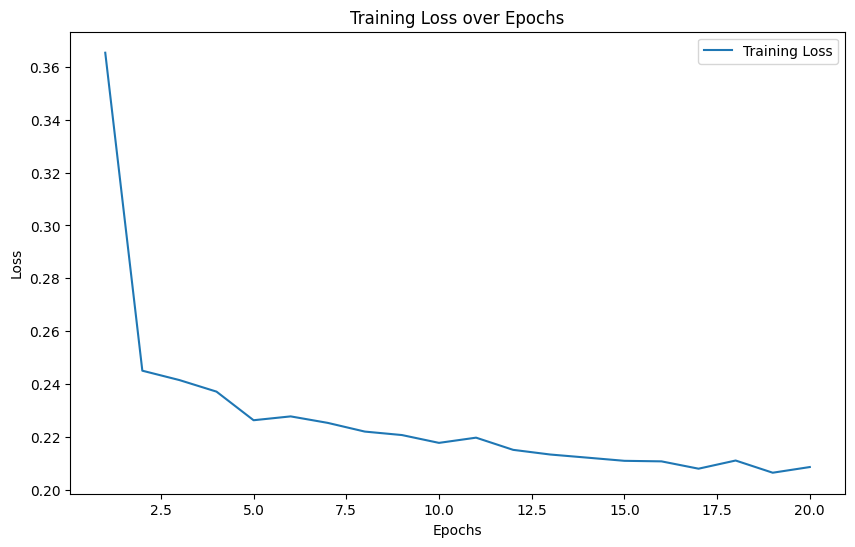

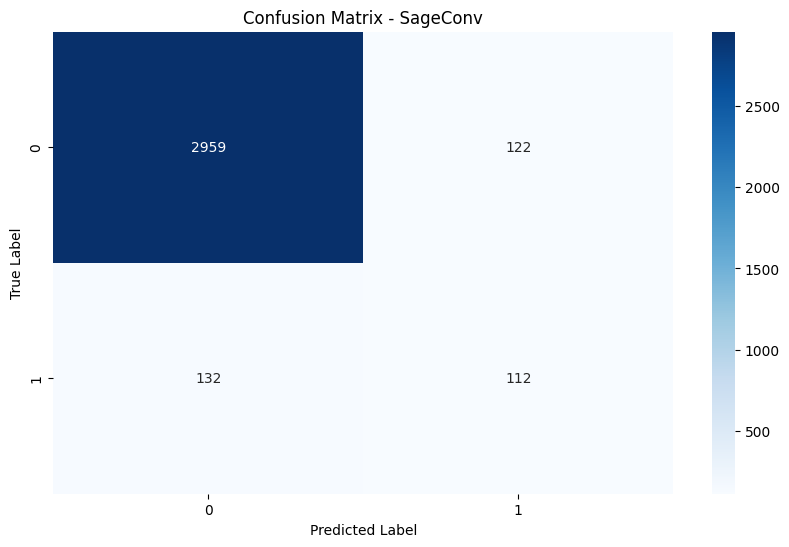

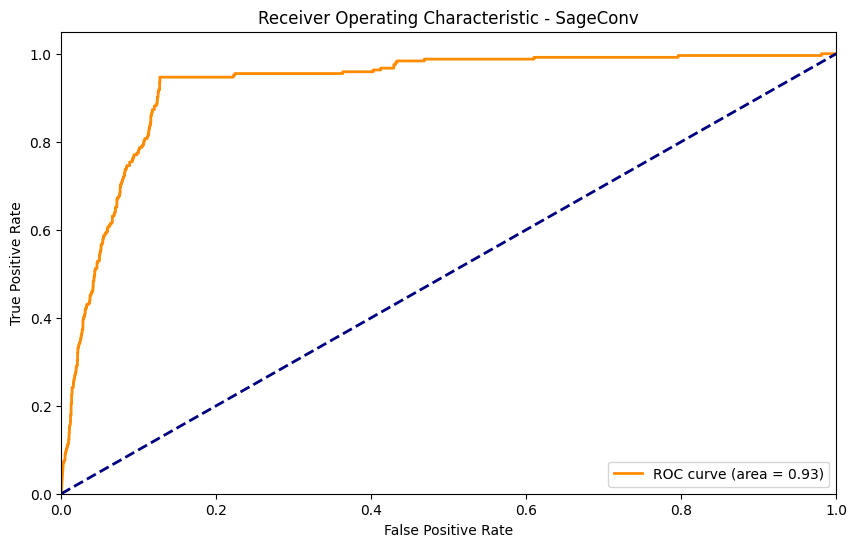

{'type10_label': 0.923609022556391}
type1_label_


100%|██████████| 2079/2079 [02:41<00:00, 12.90it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.7010354692845241
Epoch 2, Loss: 0.36742812306012795
Epoch 3, Loss: 0.333085251081249
Epoch 4, Loss: 0.31990986770909763
Epoch 5, Loss: 0.3172481037352396
Epoch 6, Loss: 0.31565085288299166
Epoch 7, Loss: 0.29925882897299266
Epoch 8, Loss: 0.30430486377166666
Epoch 9, Loss: 0.29440792811953503
Epoch 10, Loss: 0.29523838602978253
Epoch 11, Loss: 0.29880270523869473
Epoch 12, Loss: 0.2943939565397475
Epoch 13, Loss: 0.2955132434549539
Epoch 14, Loss: 0.29610748224608274
Epoch 15, Loss: 0.29231735740018927
Epoch 16, Loss: 0.2950988690895231
Epoch 17, Loss: 0.2941397609918014
Epoch 18, Loss: 0.2924399192890395
Epoch 19, Loss: 0.290760464804328
Epoch 20, Loss: 0.2896235085132977


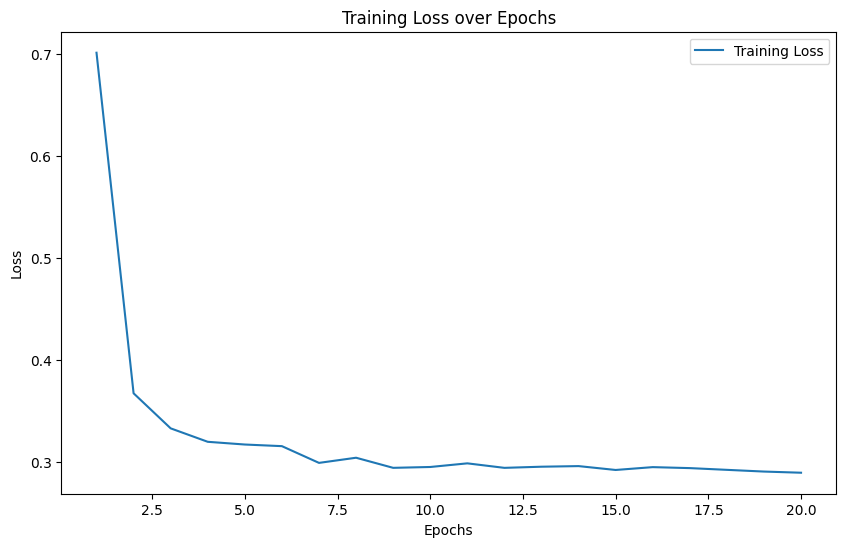

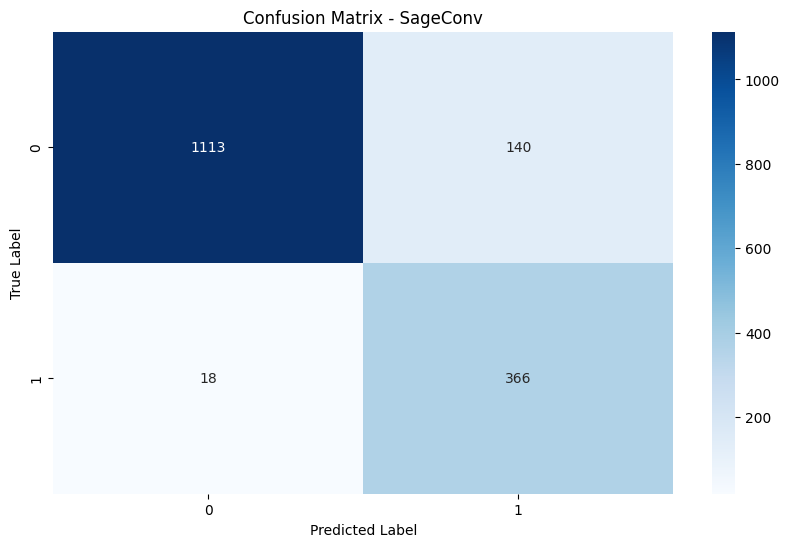

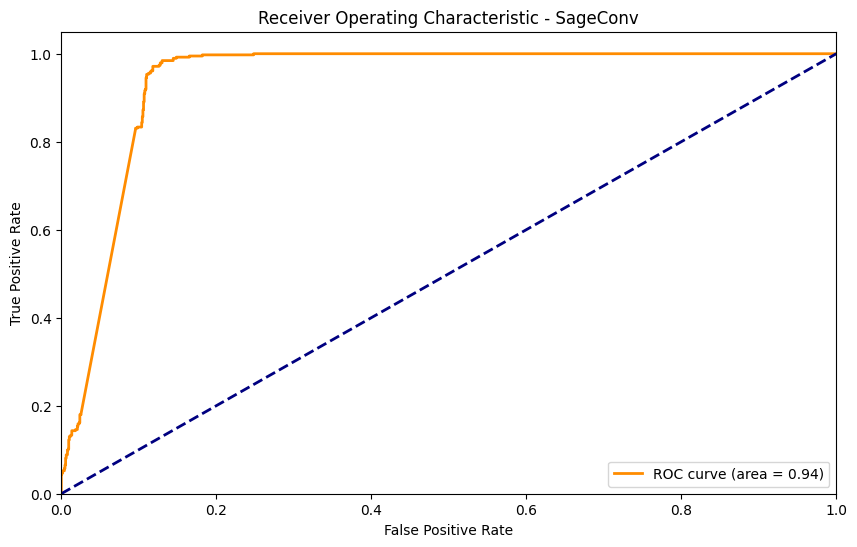

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994}
type2_label_


100%|██████████| 1342/1342 [02:00<00:00, 11.12it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.3123126833078762
Epoch 2, Loss: 0.18669228504101434
Epoch 3, Loss: 0.1615934617817402
Epoch 4, Loss: 0.1553204094370206
Epoch 5, Loss: 0.15392784147212904
Epoch 6, Loss: 0.15149157804747423
Epoch 7, Loss: 0.14856838726749022
Epoch 8, Loss: 0.14565471944709618
Epoch 9, Loss: 0.1438236547013124
Epoch 10, Loss: 0.14296944830566644
Epoch 11, Loss: 0.1418446484953165
Epoch 12, Loss: 0.13956591207534075
Epoch 13, Loss: 0.14048878215253352
Epoch 14, Loss: 0.13882660555342832
Epoch 15, Loss: 0.14015512547145287
Epoch 16, Loss: 0.14078056750198206
Epoch 17, Loss: 0.13768676271041233
Epoch 18, Loss: 0.1353962603956461
Epoch 19, Loss: 0.13530057376871507
Epoch 20, Loss: 0.13822810184210538


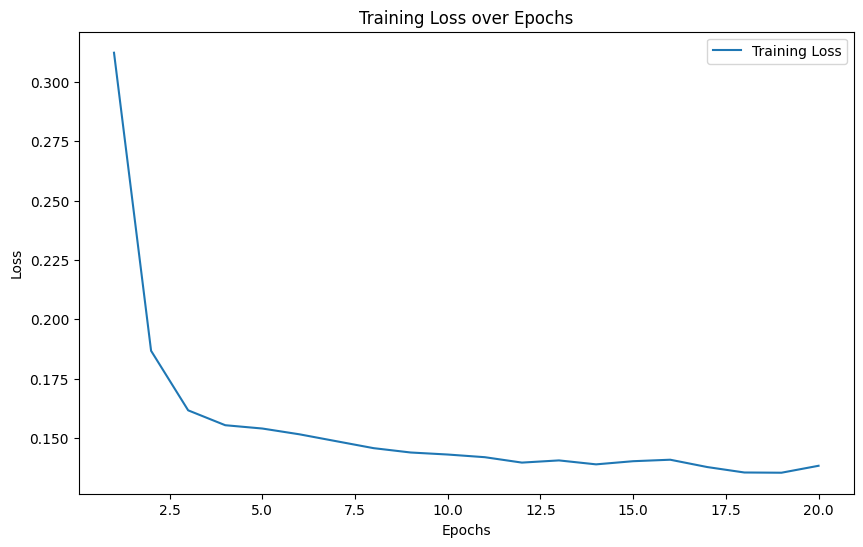

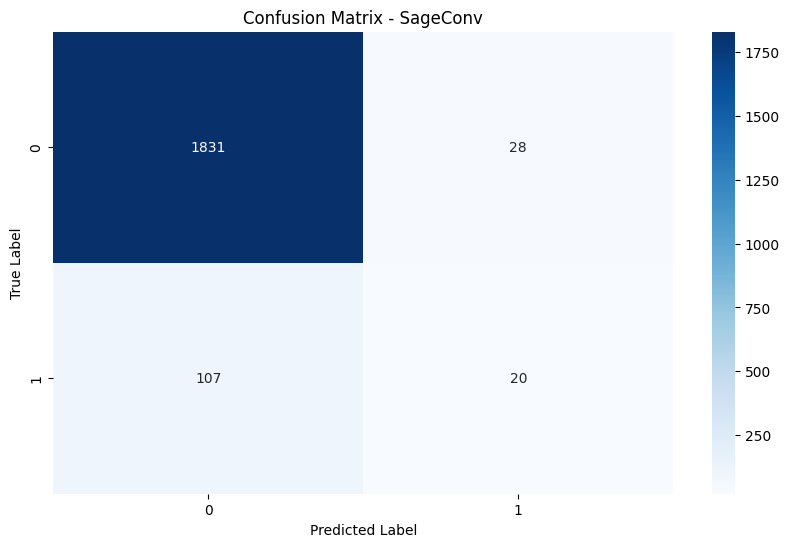

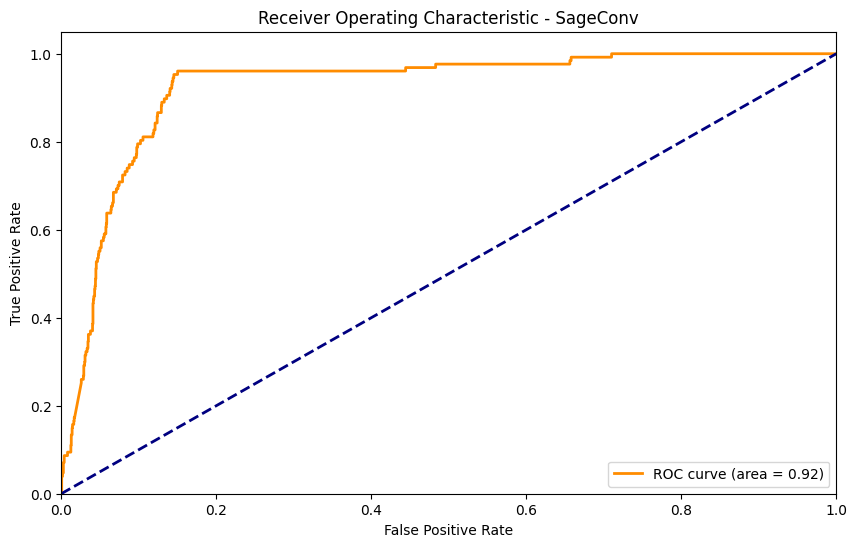

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429}
type3_label_


100%|██████████| 1975/1975 [02:46<00:00, 11.83it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.5518529194999825
Epoch 2, Loss: 0.2867298394610936
Epoch 3, Loss: 0.2622238507663662
Epoch 4, Loss: 0.25436266215348785
Epoch 5, Loss: 0.247190427119759
Epoch 6, Loss: 0.24567634248259393
Epoch 7, Loss: 0.23967259648171338
Epoch 8, Loss: 0.23902794320813633
Epoch 9, Loss: 0.2399389175698161
Epoch 10, Loss: 0.23669108358973806
Epoch 11, Loss: 0.23439196150072597
Epoch 12, Loss: 0.23294369004328142
Epoch 13, Loss: 0.2328896989029917
Epoch 14, Loss: 0.22931165849281984
Epoch 15, Loss: 0.22921361215412617
Epoch 16, Loss: 0.23092463494024493
Epoch 17, Loss: 0.2317417570474473
Epoch 18, Loss: 0.23024556057696993
Epoch 19, Loss: 0.22946811450475996
Epoch 20, Loss: 0.22865262009542098


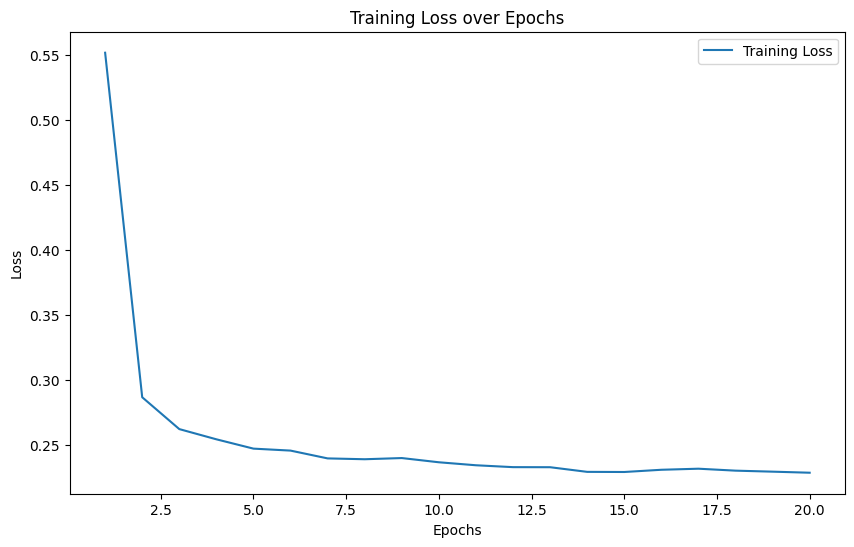

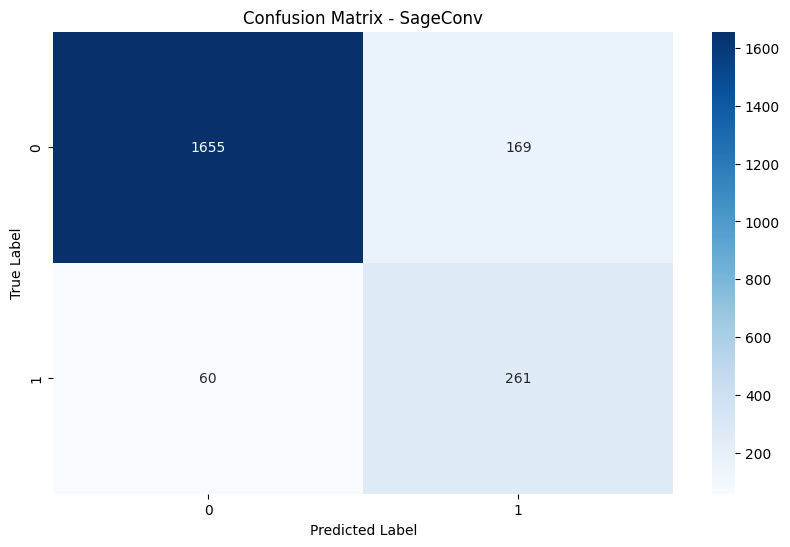

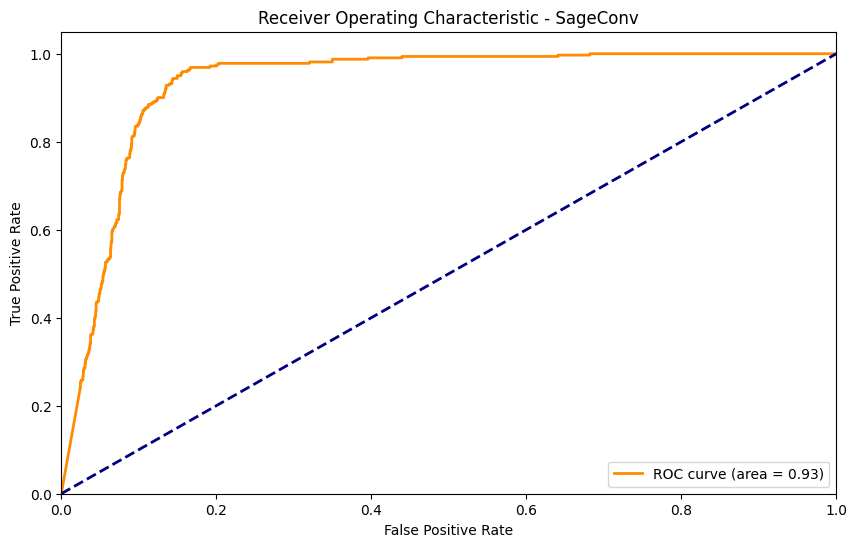

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429, 'type3_label_': 0.8932400932400932}
type4_label_


100%|██████████| 1334/1334 [02:06<00:00, 10.57it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.2757521747301022
Epoch 2, Loss: 0.1620972176392873
Epoch 3, Loss: 0.1458773239205281
Epoch 4, Loss: 0.13207186479121447
Epoch 5, Loss: 0.13039453116556007
Epoch 6, Loss: 0.12663499278326829
Epoch 7, Loss: 0.12790806169311206
Epoch 8, Loss: 0.12650226770589748
Epoch 9, Loss: 0.1262009964014093
Epoch 10, Loss: 0.12330951790014903
Epoch 11, Loss: 0.12312240805476904
Epoch 12, Loss: 0.1212260264903307
Epoch 13, Loss: 0.12410660553723574
Epoch 14, Loss: 0.1211621223638455
Epoch 15, Loss: 0.1181308425962925
Epoch 16, Loss: 0.11824491191655398
Epoch 17, Loss: 0.1186374499152104
Epoch 18, Loss: 0.11954737852017085
Epoch 19, Loss: 0.11820692215114832
Epoch 20, Loss: 0.1179241488998135


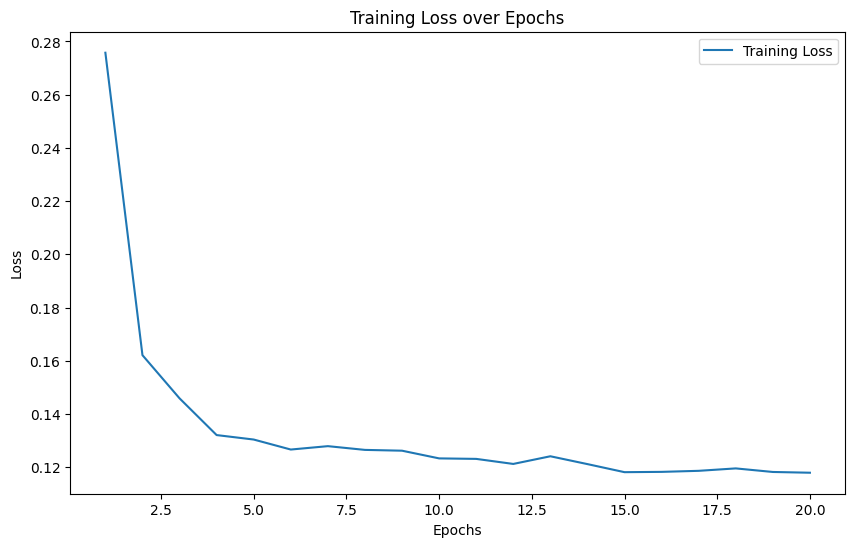

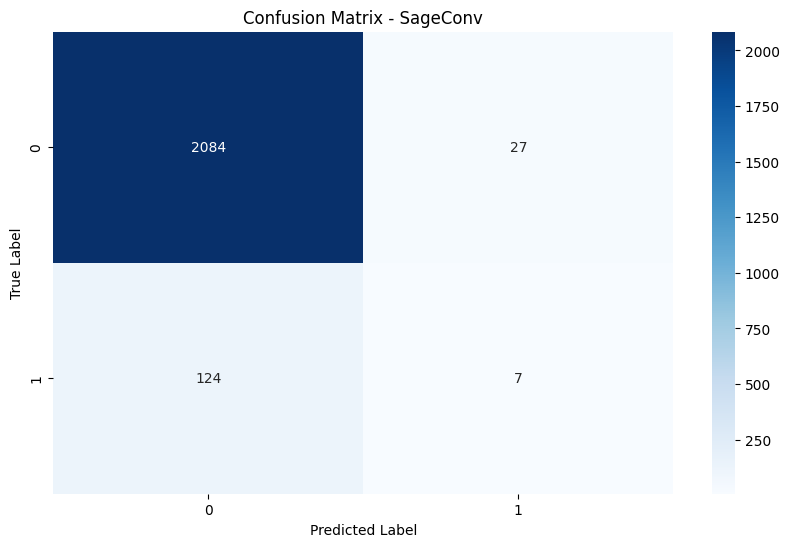

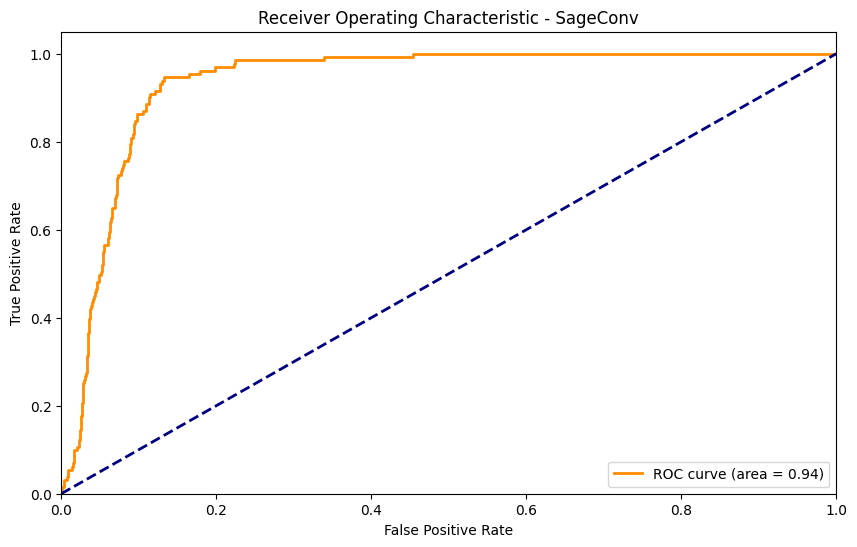

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429, 'type3_label_': 0.8932400932400932, 'type4_label_': 0.932649420160571}
type5_label_


100%|██████████| 1807/1807 [02:47<00:00, 10.82it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.2925007555866614
Epoch 2, Loss: 0.19088928583078085
Epoch 3, Loss: 0.17464857138693332
Epoch 4, Loss: 0.16953705446794629
Epoch 5, Loss: 0.16219657780602575
Epoch 6, Loss: 0.16081635616719722
Epoch 7, Loss: 0.1573579623363912
Epoch 8, Loss: 0.15542997550219298
Epoch 9, Loss: 0.1563036718405783
Epoch 10, Loss: 0.1560094838961959
Epoch 11, Loss: 0.15477957539260387
Epoch 12, Loss: 0.15484011955559254
Epoch 13, Loss: 0.15489577455446124
Epoch 14, Loss: 0.15415119929239154
Epoch 15, Loss: 0.15242874911054968
Epoch 16, Loss: 0.14974690582603217
Epoch 17, Loss: 0.15038391556590797
Epoch 18, Loss: 0.1489450757391751
Epoch 19, Loss: 0.1493064420297742
Epoch 20, Loss: 0.147909695841372


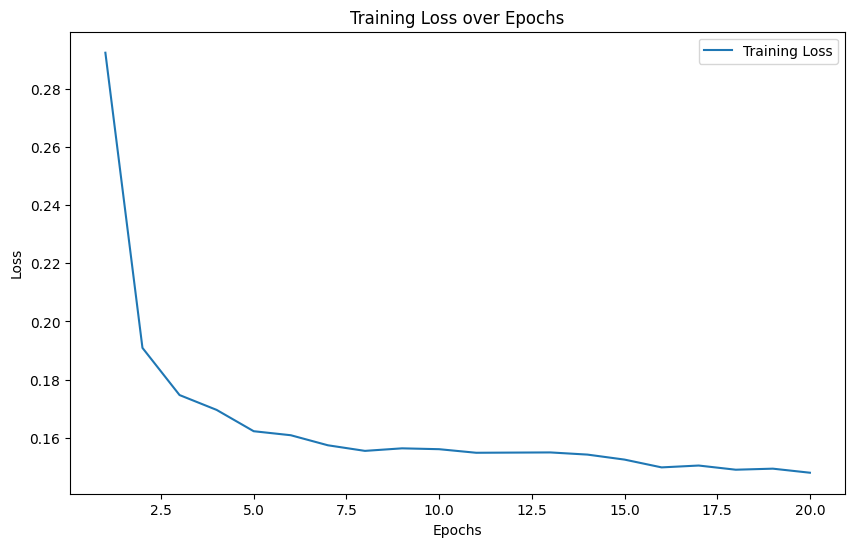

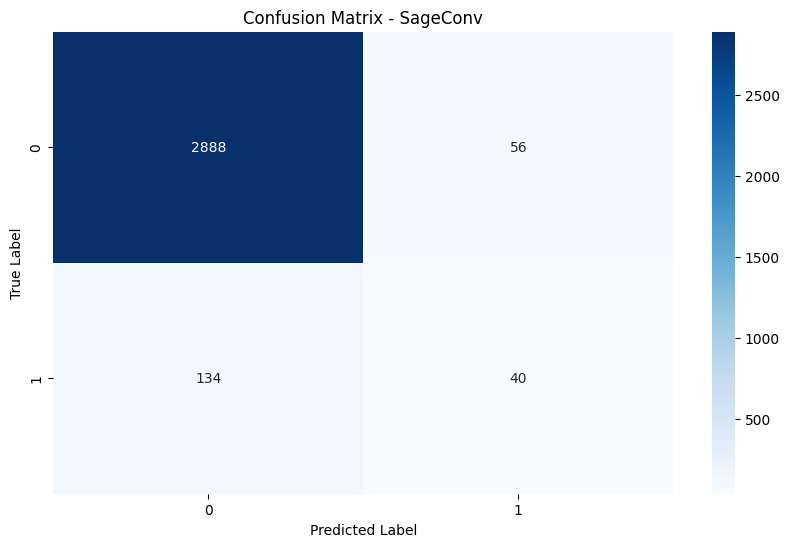

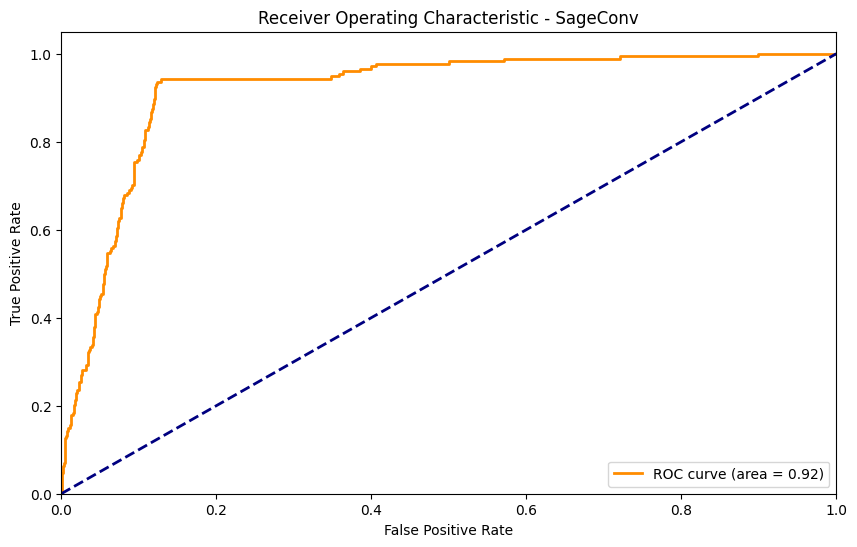

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429, 'type3_label_': 0.8932400932400932, 'type4_label_': 0.932649420160571, 'type5_label_': 0.9390635022450289}
type6_label_


100%|██████████| 2414/2414 [03:44<00:00, 10.73it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.29974641000746555
Epoch 2, Loss: 0.16990286378927952
Epoch 3, Loss: 0.16840087861384986
Epoch 4, Loss: 0.1617640061128252
Epoch 5, Loss: 0.1544913039454874
Epoch 6, Loss: 0.15299486161543513
Epoch 7, Loss: 0.1525343438645579
Epoch 8, Loss: 0.1536524661307065
Epoch 9, Loss: 0.14946598777512335
Epoch 10, Loss: 0.14953802431107693
Epoch 11, Loss: 0.1497809682392849
Epoch 12, Loss: 0.1493632668664433
Epoch 13, Loss: 0.1492238906475733
Epoch 14, Loss: 0.14904176348925763
Epoch 15, Loss: 0.14890086172886616
Epoch 16, Loss: 0.14802103391233482
Epoch 17, Loss: 0.1464844225853119
Epoch 18, Loss: 0.14574800565276505
Epoch 19, Loss: 0.1465391326203661
Epoch 20, Loss: 0.1456422341179173


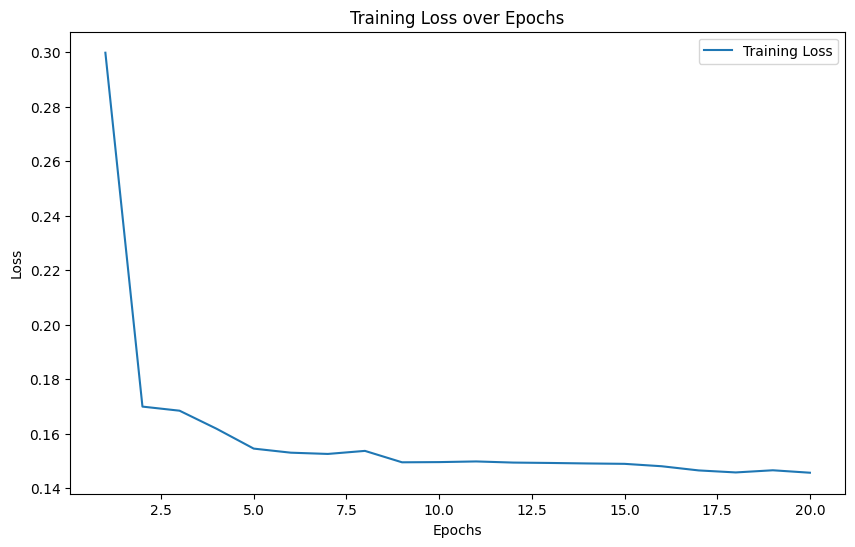

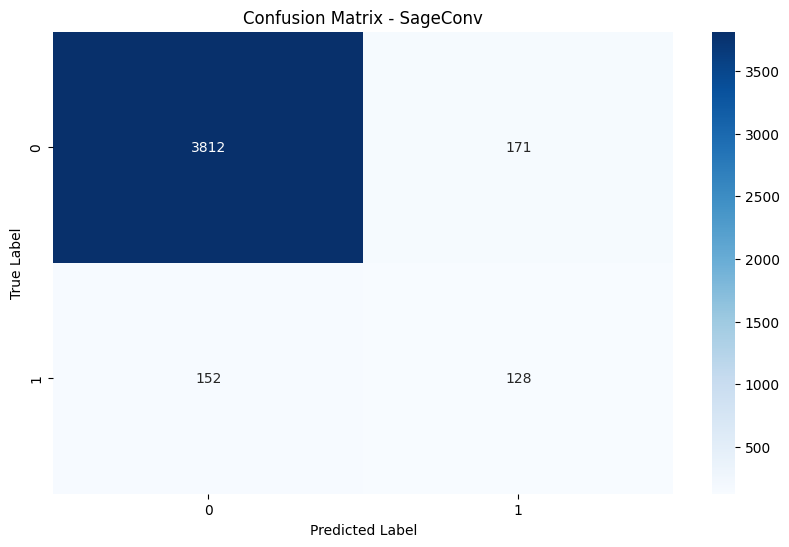

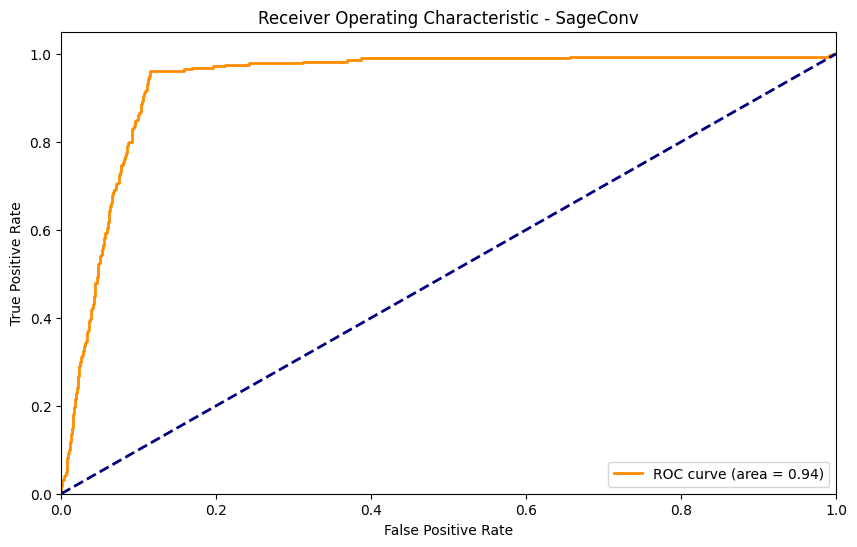

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429, 'type3_label_': 0.8932400932400932, 'type4_label_': 0.932649420160571, 'type5_label_': 0.9390635022450289, 'type6_label_': 0.9242317616701853}
type7_label_


100%|██████████| 2342/2342 [03:22<00:00, 11.59it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.3738153507001698
Epoch 2, Loss: 0.22371130988288385
Epoch 3, Loss: 0.2038324628240214
Epoch 4, Loss: 0.2009245971790873
Epoch 5, Loss: 0.19696592630890125
Epoch 6, Loss: 0.1949303864608877
Epoch 7, Loss: 0.19994538134107223
Epoch 8, Loss: 0.20079585424481103
Epoch 9, Loss: 0.19789740045626575
Epoch 10, Loss: 0.1974622460368734
Epoch 11, Loss: 0.20062634667668205
Epoch 12, Loss: 0.19792093594486898
Epoch 13, Loss: 0.19942495259098136
Epoch 14, Loss: 0.19564206303598788
Epoch 15, Loss: 0.19938644172193912
Epoch 16, Loss: 0.1979210963830925
Epoch 17, Loss: 0.19653289045135564
Epoch 18, Loss: 0.19678039161058572
Epoch 19, Loss: 0.19593595806509256
Epoch 20, Loss: 0.19667298353921908


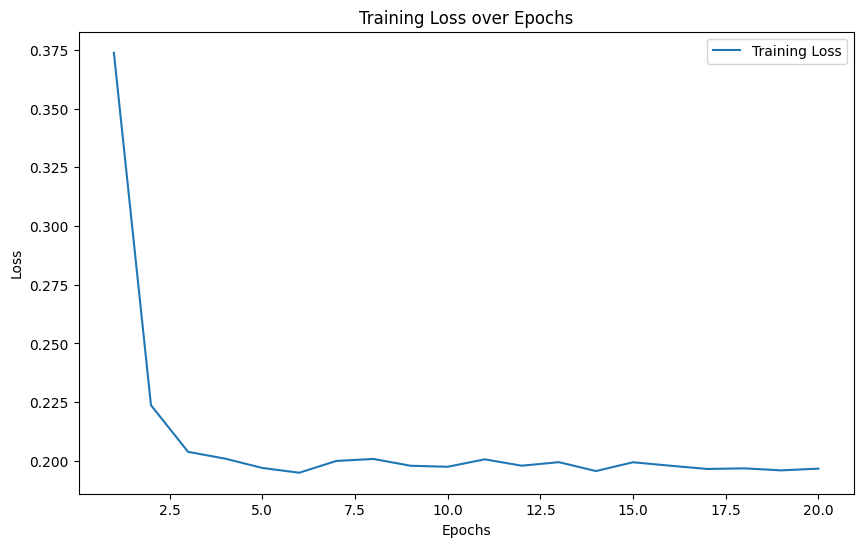

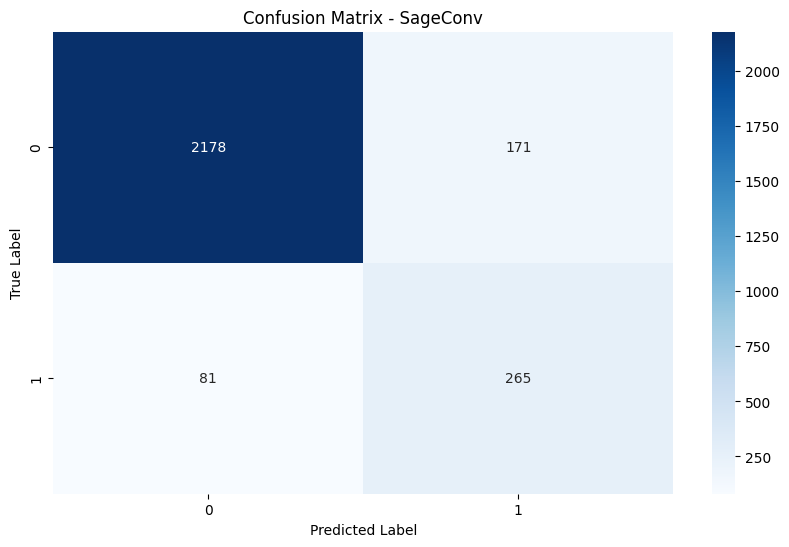

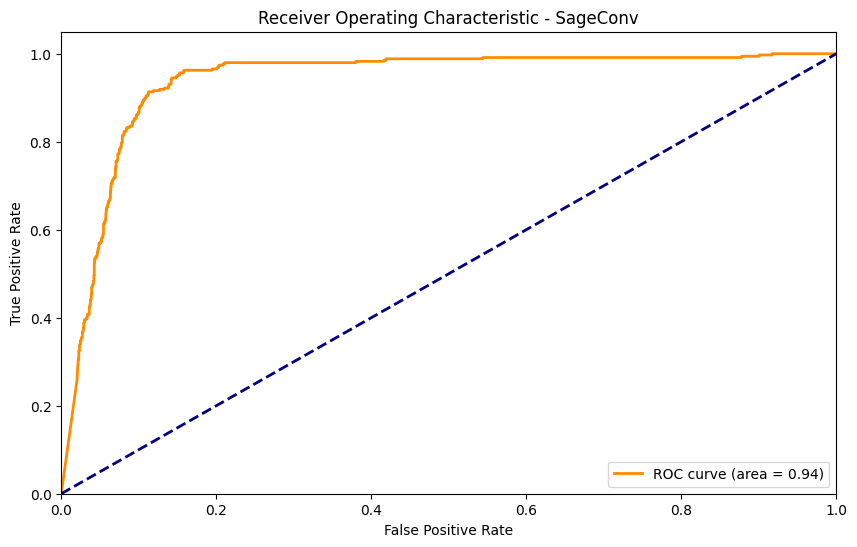

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429, 'type3_label_': 0.8932400932400932, 'type4_label_': 0.932649420160571, 'type5_label_': 0.9390635022450289, 'type6_label_': 0.9242317616701853, 'type7_label_': 0.9064935064935065}
type8_label_


100%|██████████| 2658/2658 [03:47<00:00, 11.70it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.5230389824216017
Epoch 2, Loss: 0.2532863995155035
Epoch 3, Loss: 0.2375831157284773
Epoch 4, Loss: 0.23138758047657498
Epoch 5, Loss: 0.23263436249630937
Epoch 6, Loss: 0.22423424568595524
Epoch 7, Loss: 0.22032869414631592
Epoch 8, Loss: 0.22191931840853166
Epoch 9, Loss: 0.219202330620107
Epoch 10, Loss: 0.219895598936384
Epoch 11, Loss: 0.21708321508209585
Epoch 12, Loss: 0.21801389182396866
Epoch 13, Loss: 0.21532835473574824
Epoch 14, Loss: 0.2149862307992022
Epoch 15, Loss: 0.21806646750892622
Epoch 16, Loss: 0.2149441246322151
Epoch 17, Loss: 0.2113440789408603
Epoch 18, Loss: 0.2135260675923299
Epoch 19, Loss: 0.21657083808618077
Epoch 20, Loss: 0.21306184893947536


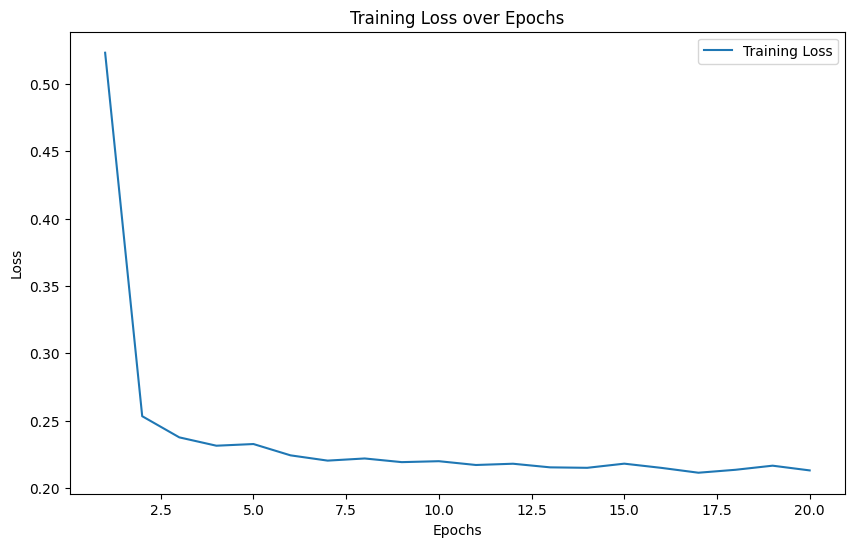

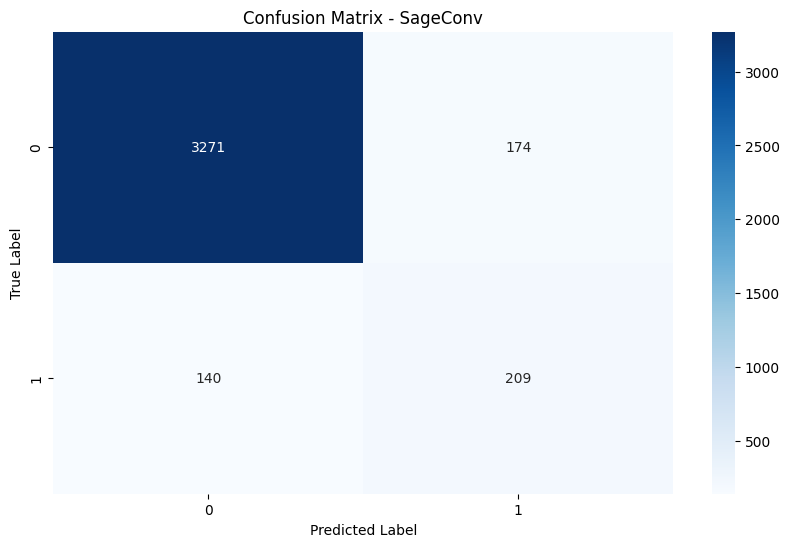

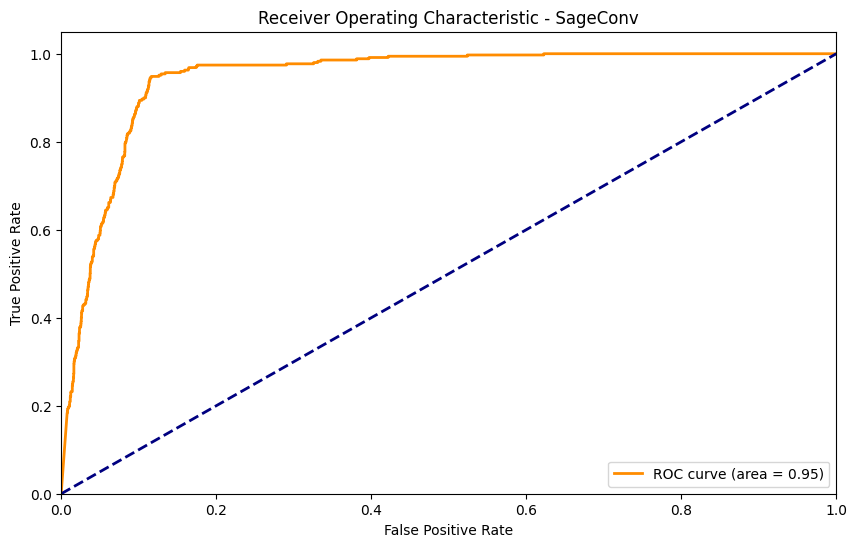

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429, 'type3_label_': 0.8932400932400932, 'type4_label_': 0.932649420160571, 'type5_label_': 0.9390635022450289, 'type6_label_': 0.9242317616701853, 'type7_label_': 0.9064935064935065, 'type8_label_': 0.9172377438060095}
type9_label_


100%|██████████| 2304/2304 [03:28<00:00, 11.06it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.31933322008333953
Epoch 2, Loss: 0.1833230632485128
Epoch 3, Loss: 0.16353644841514967
Epoch 4, Loss: 0.16072625334502436
Epoch 5, Loss: 0.16098781598403172
Epoch 6, Loss: 0.1596856157788459
Epoch 7, Loss: 0.15965007994250924
Epoch 8, Loss: 0.16001022493868483
Epoch 9, Loss: 0.1609229477597218
Epoch 10, Loss: 0.16068721445752124
Epoch 11, Loss: 0.1589452153546553
Epoch 12, Loss: 0.16138183683449148
Epoch 13, Loss: 0.15867489711472801
Epoch 14, Loss: 0.1571378766686893
Epoch 15, Loss: 0.15759550257786817
Epoch 16, Loss: 0.15632295013204509
Epoch 17, Loss: 0.15606429519168302
Epoch 18, Loss: 0.15662560330740377
Epoch 19, Loss: 0.15508763481150656
Epoch 20, Loss: 0.154994659454507


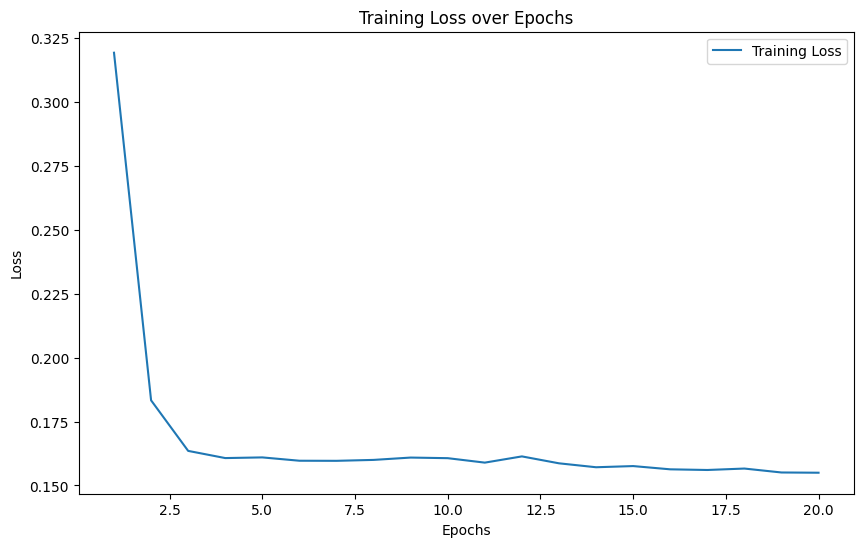

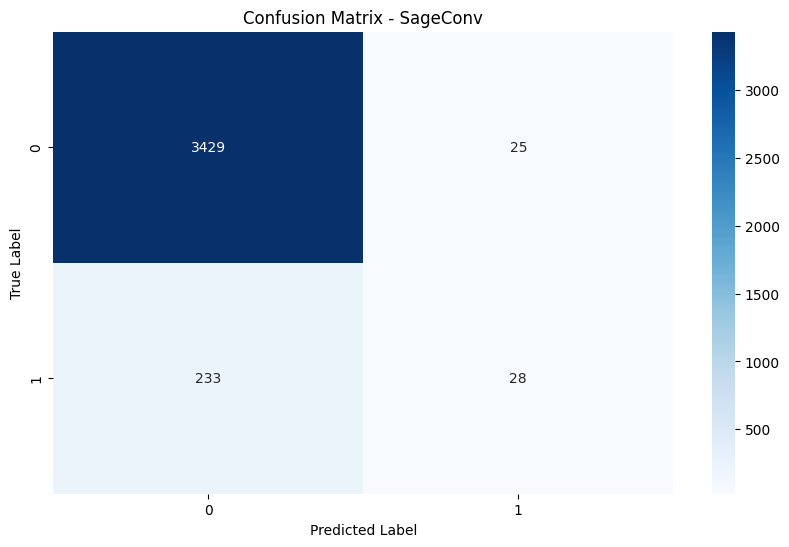

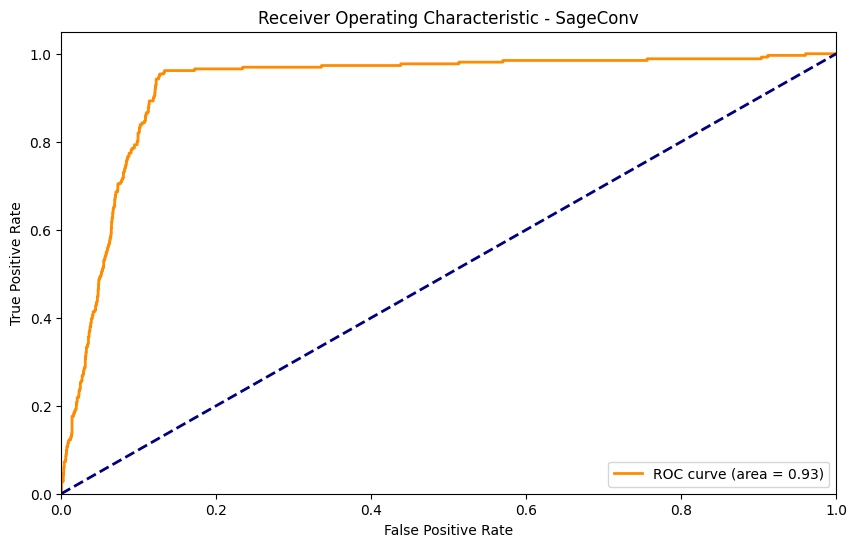

{'type10_label': 0.923609022556391, 'type1_label_': 0.9034819792302994, 'type2_label_': 0.93202416918429, 'type3_label_': 0.8932400932400932, 'type4_label_': 0.932649420160571, 'type5_label_': 0.9390635022450289, 'type6_label_': 0.9242317616701853, 'type7_label_': 0.9064935064935065, 'type8_label_': 0.9172377438060095, 'type9_label_': 0.9305518169582773}


In [8]:
new_execution_flag = assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)
else:
    folder_name = input("Input folder name from all_execution_data")

result_dict = {}
for file_path in xlsx_files:
    

    if new_execution_flag == 1:
        data = pd.read_excel(file_path)
        data['can_id'] = data['can_id'].astype(str)
    
    label_key = os.path.basename(file_path).split('.')[0][0:12]
    print(label_key)

    output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
    visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
    result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    if new_execution_flag == 1:
        pyg_data_list = preprocess_data(data,output_dir,visualization_dir)
    else:
        pyg_data_list = load_saved_graphs(output_dir)


    train_size = int(0.7 * len(pyg_data_list))
    train_data = pyg_data_list[:train_size]
    test_data = pyg_data_list[train_size:]

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    _,_,acc = run_SageConv(train_loader,test_loader,result_dir)
    result_dict[label_key] = acc
    print(result_dict)


In [9]:
result_dict


{'type10_label': 0.923609022556391,
 'type1_label_': 0.9034819792302994,
 'type2_label_': 0.93202416918429,
 'type3_label_': 0.8932400932400932,
 'type4_label_': 0.932649420160571,
 'type5_label_': 0.9390635022450289,
 'type6_label_': 0.9242317616701853,
 'type7_label_': 0.9064935064935065,
 'type8_label_': 0.9172377438060095,
 'type9_label_': 0.9305518169582773}

In [ ]:
assigned_value